In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from rcgp.morcgp import MOGPRegressor, MORCGPRegressor_PM, MORCGP
from rcgp.kernels import ConstantMean, RBFKernel
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import MinCovDet

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 24,    
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 20,
    'lines.linewidth': 6,    
    'lines.markersize': 7  
})

[[1.999396 1.249976]
 [1.249976 1.00048 ]]


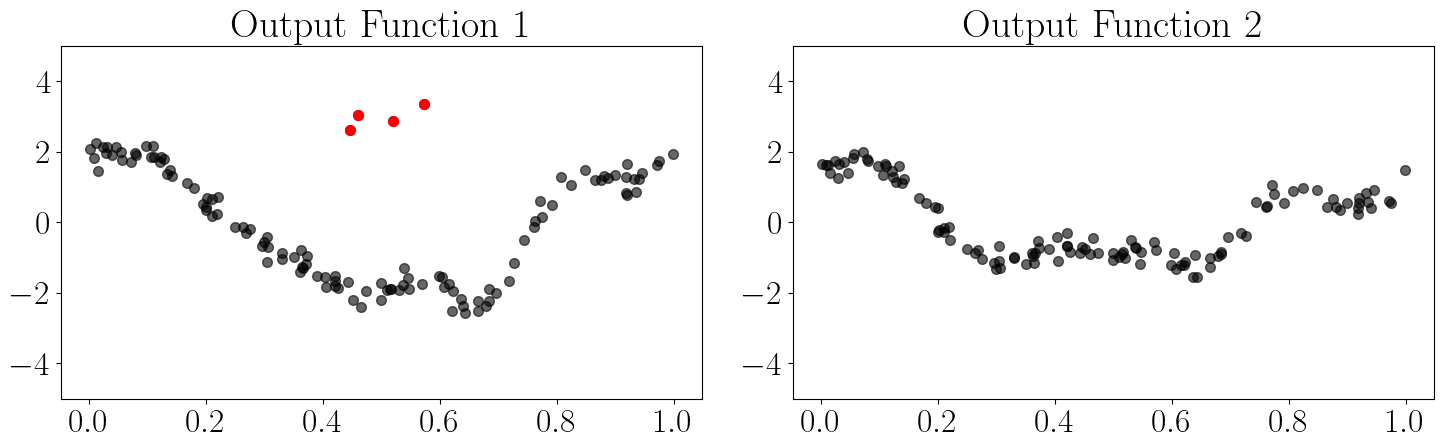

In [17]:
np.random.seed(15)
# Initialisation
constant_mean = 0
length_scale = 0.1
variance = 1
n_outputs = 2
n_points = 120
overlap_ratio = 1
epsilon = 0.04

A = np.array([[1.414, 0], 
    [0.884, 0.468]])
B = A @ A.T
print(B)

D = B.shape[0]

noise1 = 0.05
noise2 = 0.05
noise = np.array([noise1, noise2])
if noise.shape[0] == 1:
    noise_matrix = noise * np.eye(D)
else:
    noise_matrix = np.diag(noise)

# Simulation
mean_func = ConstantMean(constant=constant_mean)
rbf_kernel = RBFKernel(lengthscale=length_scale, variance=1)

x_train = np.sort(np.random.uniform(0, 1, n_points)).reshape(-1, 1)
N = len(x_train)
kernel_train = rbf_kernel(x_train, x_train)
K_train = np.kron(B, kernel_train)
K_train_noise = K_train + np.kron(noise_matrix, np.eye(len(x_train))) + 1e-6 * np.eye(len(x_train) * D)
y_train = np.random.multivariate_normal(np.tile(mean_func(x_train).flatten(), D), K_train_noise).reshape(D, -1).T

outlier_range = np.where((x_train >= 0.42) & (x_train <= 0.58))[0]
outlier_indices = np.random.choice(outlier_range, int(epsilon*n_points), replace=False)
y_train[outlier_indices, 0] = np.random.normal(loc=2.5, scale=0.5, size=outlier_indices.shape[0])
mask = np.ones(len(x_train), dtype=bool)
mask[outlier_indices] = False

y_train -= np.mean(y_train, axis=0)

x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'o', color='black', alpha=0.6, label=f'Output {i+1}')
    if i == 0:
        axs[i].plot(x_train.flatten()[~mask], y_train[:, i][~mask], 'o', color='red', label='Outlier points')
    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-5, 5])

plt.tight_layout()
plt.show()

In [18]:
# MOGP
mogp = MOGPRegressor(mean = 0, length_scale=length_scale, noise = noise, A=A)
mogp.fit(x_train, y_train)

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu_mogp, var_mogp = mogp.predict(x_test)
std_mogp = np.sqrt(var_mogp + mogp.noise)

In [19]:
mcd = MinCovDet(support_fraction=0.9).fit(y_train)
robust_covariance = mcd.covariance_
empty_noise = np.array([1e-6, 1e-6])
print(robust_covariance)

morcgp = MORCGP(mean=0, length_scale=length_scale, noise_var=noise, A=A)
morcgp.fit(x_train, y_train, epsilons=np.array([epsilon, 0]))

x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu_morcgp, var_morcgp = morcgp.predict(x_test)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise_var)

[[2.43543823 1.45235352]
 [1.45235352 1.06955011]]


In [20]:
# MORCGP (w_RCGP)
morcgp = MORCGPRegressor_PM(mean = 0, length_scale=length_scale, noise = noise, A=A, epsilons=np.array([epsilon, 0]))
morcgp.fit(x_train, y_train)

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu_pm, var_pm = morcgp.predict(x_test)
std_pm = np.sqrt(var_pm + morcgp.noise)

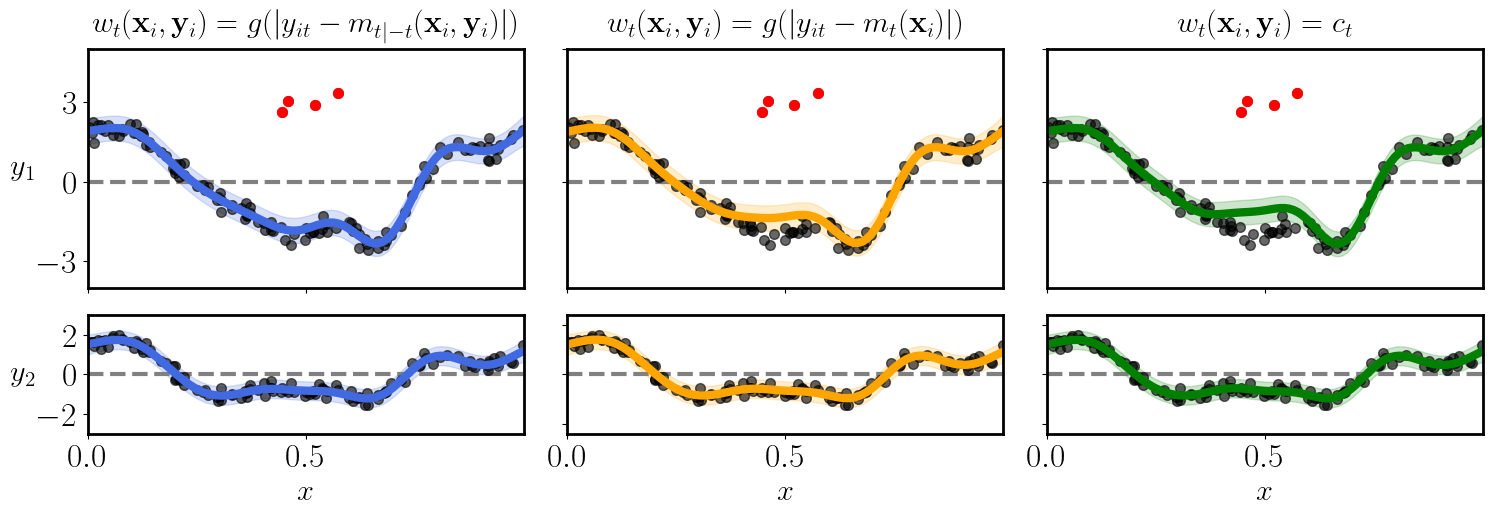

In [25]:
import matplotlib.pyplot as plt

models = [
    {"mu": mu_morcgp, "std": std_morcgp, "label": r"$w_t(\mathbf{x}_i, \mathbf{y}_i) = g(|y_{it} - m_{t|-t}(\mathbf{x}_i, \mathbf{y}_i)|)$", "color": "royalblue"},
    {"mu": mu_pm, "std": std_pm, "label": r"$w_t(\mathbf{x}_i, \mathbf{y}_i) = g(|y_{it} - m_t(\mathbf{x}_i)|)$", "color": "orange"},
    {"mu": mu_mogp, "std": std_mogp, "label": r"$w_t(\mathbf{x}_i, \mathbf{y}_i) = c_t$", "color": "green"},
]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 5), gridspec_kw={'height_ratios': [1, 0.5]})

def plot_model(ax, i, mu, std, color, label):
    ax.axhline(0, color='grey', linestyle='--', linewidth=3)  # Add y=0 line
    ax.plot(x_train.flatten(), y_train[:, i], 'o', color='black', alpha=0.6)
    if i == 0:
        ax.plot(x_train.flatten()[~mask], y_train[:, i][~mask], 'o', color='red', label='Outliers')
    ax.plot(x_test.flatten(), mu[:, i], '-', color=color, label=label)
    ax.fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], color=color, alpha=0.2)
    ax.set_xlim([0, 1])
    ax.set_xticks([0, 0.5])
    if i == 0:
        ax.set_ylim([-4, 5])
    else:
        ax.set_ylim([-3, 3])

for col, model in enumerate(models):
    for row in range(2):
        ax = axes[row, col]
        plot_model(ax, row, model["mu"], model["std"], model["color"], model["label"])

for row in range(2):
    for col in range(3):
        ax = axes[row, col]
        if col > 0:
            ax.set_yticklabels([])
        if row == 0:
            ax.set_xticklabels([])
        else:
            ax.xaxis.set_tick_params(labelbottom=True)
        for spine in ax.spines.values():
            spine.set_linewidth(2)

axes[0, 0].set_ylabel('$y_1$', fontsize=22, labelpad=18, rotation=0)
axes[1, 0].set_ylabel('$y_2$', fontsize=22, labelpad=18, rotation=0)

axes[0, 0].yaxis.set_label_coords(-0.15, 0.45)
axes[1, 0].yaxis.set_label_coords(-0.15, 0.4)

axes[0, 0].set_yticks([-3, 0, 3])
axes[1, 0].set_yticks([-2, 0, 2])

for col in range(3):
    axes[1, col].set_xlabel(r'$x$', fontsize=22)

for col, model in enumerate(models):
    axes[0, col].set_title(model["label"], fontsize=22, pad=12)

plt.subplots_adjust(wspace=0.1, hspace=0.15)
plt.show()

# fig.savefig("./results/synthetic_MORCGPs_MOGP2.pdf", format='pdf', bbox_inches='tight')

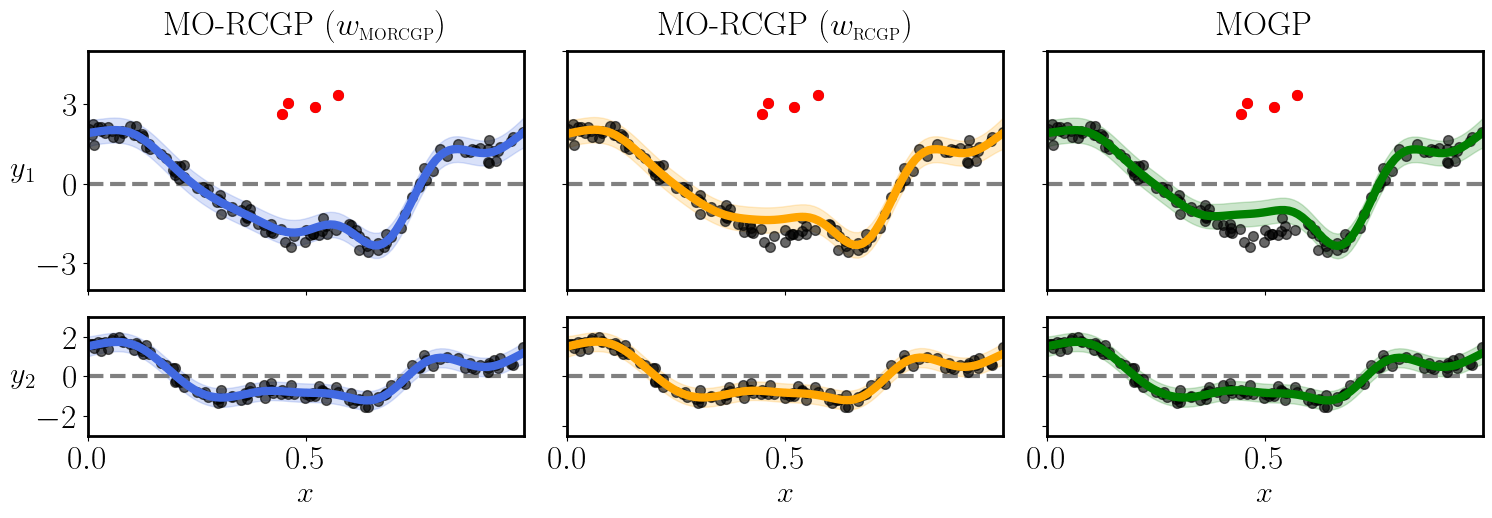

In [24]:
import matplotlib.pyplot as plt

models = [
    {"mu": mu_morcgp, "std": std_morcgp, "label": r"MO-RCGP ($w_{\scriptscriptstyle\textrm{MORCGP}}$)", "color": "royalblue"},
    {"mu": mu_pm, "std": std_pm, "label": r"MO-RCGP ($w_{\scriptscriptstyle\textrm{RCGP}}$)", "color": "orange"},
    {"mu": mu_mogp, "std": std_mogp, "label": r"MOGP", "color": "green"},
]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 5), gridspec_kw={'height_ratios': [1, 0.5]})

def plot_model(ax, i, mu, std, color, label):
    ax.axhline(0, color='grey', linestyle='--', linewidth=3)  # Add y=0 line
    ax.plot(x_train.flatten(), y_train[:, i], 'o', color='black', alpha=0.6)
    if i == 0:
        ax.plot(x_train.flatten()[~mask], y_train[:, i][~mask], 'o', color='red', label='Outliers')
    ax.plot(x_test.flatten(), mu[:, i], '-', color=color, label=label)
    ax.fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], color=color, alpha=0.2)
    ax.set_xlim([0, 1])
    ax.set_xticks([0, 0.5])
    if i == 0:
        ax.set_ylim([-4, 5])
    else:
        ax.set_ylim([-3, 3])

for col, model in enumerate(models):
    for row in range(2):
        ax = axes[row, col]
        plot_model(ax, row, model["mu"], model["std"], model["color"], model["label"])

for row in range(2):
    for col in range(3):
        ax = axes[row, col]
        if col > 0:
            ax.set_yticklabels([])
        if row == 0:
            ax.set_xticklabels([])
        else:
            ax.xaxis.set_tick_params(labelbottom=True)
        for spine in ax.spines.values():
            spine.set_linewidth(2)

axes[0, 0].set_ylabel('$y_1$', fontsize=22, labelpad=18, rotation=0)
axes[1, 0].set_ylabel('$y_2$', fontsize=22, labelpad=18, rotation=0)

axes[0, 0].yaxis.set_label_coords(-0.15, 0.45)
axes[1, 0].yaxis.set_label_coords(-0.15, 0.4)

axes[0, 0].set_yticks([-3, 0, 3])
axes[1, 0].set_yticks([-2, 0, 2])

for col in range(3):
    axes[1, col].set_xlabel(r'$x$', fontsize=22)

for col, model in enumerate(models):
    axes[0, col].set_title(model["label"], fontsize=24, pad=12)

plt.subplots_adjust(wspace=0.1, hspace=0.15)
plt.show()

# fig.savefig("./results/synthetic_MORCGPs_MOGP2.pdf", format='pdf', bbox_inches='tight')